In [666]:
# Importing the libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

from category_encoders import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# I. Importing and Cleaning Data

In [667]:
salary_df = pd.read_csv("ds_salaries.csv")
salary_df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [668]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [669]:
salary_df.select_dtypes(exclude='object').describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [670]:
salary_df.select_dtypes(include='object').describe()

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,3755,3755,3755,3755,3755,3755,3755
unique,4,4,93,20,78,72,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,2516,3718,1040,3224,3004,3040,3153


In [671]:
for feature in salary_df.columns:
    if len(salary_df[feature].value_counts())<10:
        print(salary_df[feature].value_counts())

work_year
2023    1785
2022    1664
2021     230
2020      76
Name: count, dtype: int64
experience_level
SE    2516
MI     805
EN     320
EX     114
Name: count, dtype: int64
employment_type
FT    3718
PT      17
CT      10
FL      10
Name: count, dtype: int64
remote_ratio
0      1923
100    1643
50      189
Name: count, dtype: int64
company_size
M    3153
L     454
S     148
Name: count, dtype: int64


In [672]:
## group employee_residence and company_location into five regions 

continents_df = pd.read_csv("continents2.csv")

In [673]:
continents_df.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In [674]:
continents_df=continents_df[['alpha-2','region']]

In [675]:
continents_df.dropna(inplace=True)

In [676]:
continents_df['region'].value_counts()

region
Africa      59
Americas    57
Asia        51
Europe      51
Oceania     29
Name: count, dtype: int64

In [677]:
salary_df=salary_df.merge(continents_df,how='left', left_on='employee_residence', 
                         right_on='alpha-2').drop(['employee_residence','alpha-2'],
                                                  axis=1).rename(columns={"region": "employee_region"})

In [678]:
salary_df=salary_df.merge(continents_df,how='left', left_on='company_location', 
                         right_on='alpha-2').drop(['company_location','alpha-2'],
                                                  axis=1).rename(columns={"region": "company_region"})

In [679]:
salary_df.drop(['salary','salary_currency'],axis=1,inplace=True)

In [680]:
salary_df.nunique()

work_year              4
experience_level       4
employment_type        4
job_title             93
salary_in_usd       1035
remote_ratio           3
company_size           3
employee_region        5
company_region         5
dtype: int64

In [681]:
##keep top 5 mostly common job and group all rest into 'others'
ls=list(salary_df['job_title'].value_counts().index[salary_df['job_title'].value_counts().values>=37])
salary_df.job_title[~salary_df['job_title'].isin(ls)]='others'
salary_df.job_title.value_counts()

job_title
Data Engineer                1040
Data Scientist                840
Data Analyst                  612
others                        535
Machine Learning Engineer     289
Analytics Engineer            103
Data Architect                101
Research Scientist             82
Applied Scientist              58
Data Science Manager           58
Research Engineer              37
Name: count, dtype: int64

In [682]:
salary_df.work_year.unique()

array([2023, 2022, 2020, 2021], dtype=int64)

In [683]:
#researed on inflation rate from 2020-2022, and 
#set 5% as the expected annual inflation rate for 2023
inflation_df=pd.DataFrame({'work_year':[2020,2021,2022,2023],'Inflation':[0.012,0.047,0.065,0.05]})
salary_df=salary_df.merge(inflation_df,how='left',on='work_year')
salary_df['adj_salary_usd']=round(salary_df['salary_in_usd']/(1+salary_df.Inflation))
salary_df.drop(['salary_in_usd','Inflation'],axis=1,inplace=True)

In [684]:
salary_df.head()

,work_year,experience_level,employment_type,job_title,remote_ratio,company_size,employee_region,company_region,adj_salary_usd
0,2023,SE,FT,others,100,L,Europe,Europe,81759.0
1,2023,MI,CT,others,100,S,Americas,Americas,28571.0
2,2023,MI,CT,others,100,S,Americas,Americas,24286.0
3,2023,SE,FT,Data Scientist,100,M,Americas,Americas,166667.0
4,2023,SE,FT,Data Scientist,100,M,Americas,Americas,114286.0


# 2. EDA

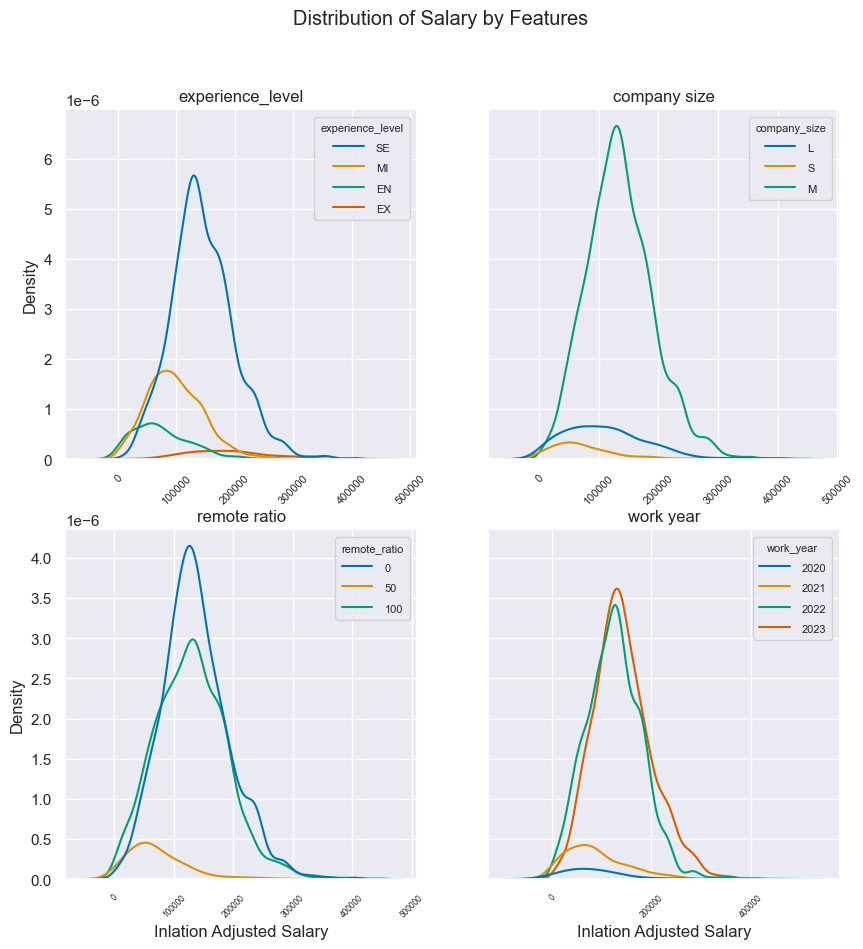

<Figure size 640x480 with 0 Axes>

In [691]:
fig,axes=plt.subplots(2,2,sharey='row',figsize=(10,10))

g00=sns.kdeplot(data=salary_df, x="adj_salary_usd", hue="experience_level",ax=axes[0,0],palette='colorblind')
g00.set(xlabel=" ",title='experience_level')
# for legend text
plt.setp(g00.get_legend().get_texts(), fontsize='8')
# for legend title
plt.setp(g00.get_legend().get_title(), fontsize='8') 
#for xticklabels
plt.setp(g00.get_xticklabels(), fontsize='8',rotation=45)


g01=sns.kdeplot(data=salary_df, x="adj_salary_usd", hue="company_size",ax=axes[0,1],palette='colorblind')
g01.set(ylabel=" ",xlabel=" ",title="company size")
# for legend text
plt.setp(g01.get_legend().get_texts(), fontsize='8') 
 # for legend title
plt.setp(g01.get_legend().get_title(), fontsize='8') 
#for xticklabels
plt.setp(g01.get_xticklabels(), fontsize='8',rotation=45)


g10=sns.kdeplot(data=salary_df, x="adj_salary_usd", hue="remote_ratio",ax=axes[1,0],palette='colorblind')
g10.set(xlabel="Inlation Adjusted Salary",title="remote ratio")
#for legend text
plt.setp(g10.get_legend().get_texts(), fontsize='8') 
 # for legend title
plt.setp(g10.get_legend().get_title(), fontsize='8') 
#for xticklabels
plt.setp(g10.get_xticklabels(), fontsize='6',rotation=45)


g11=sns.kdeplot(data=salary_df, x="adj_salary_usd", hue="work_year",ax=axes[1,1],palette='colorblind')
g11.set(ylabel=" ",xlabel="Inlation Adjusted Salary",title="work year")
# for legend title
plt.setp(g11.get_legend().get_texts(), fontsize='8') 
 # for legend title
plt.setp(g11.get_legend().get_title(), fontsize='8') 
#for xticklabels
plt.setp(g11.get_xticklabels(), fontsize='6',rotation=45)


plt.suptitle("Distribution of Salary by Features")
plt.show()

plt.savefig('Distribution of Salary by Features',dpi=100)

In [687]:
agg_job_df=salary_df.groupby('job_title')['adj_salary_usd'].agg('mean').sort_values(ascending=False).reset_index()
agg_job_df['adj_salary_usd']=round(agg_job_df['adj_salary_usd'])
agg_job_df.drop(9,inplace=True)

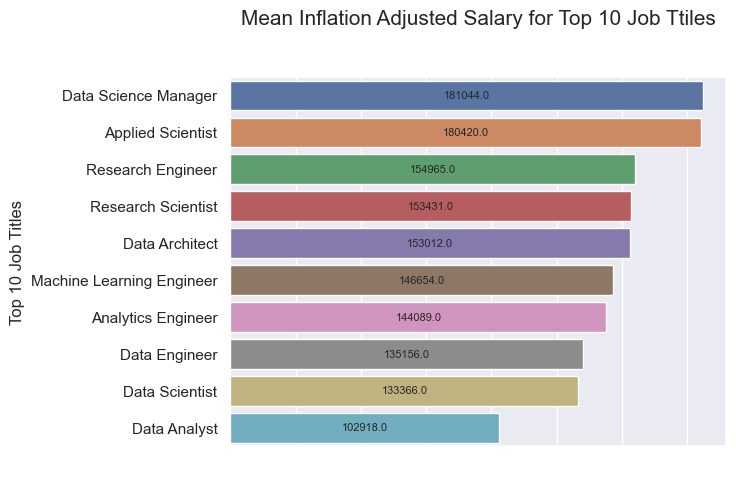

In [689]:
#sns.catplot(data=salary_df,x="employment_type",y="adj_salary_usd",kind='bar',ci=None)
fig, ax1 = plt.subplots()

g0=sns.barplot(data=agg_df,y="job_title",x="adj_salary_usd",ci=None,ax=ax1,orient='h')
# add the annotation
ax1.bar_label(ax1.containers[-1], labels=agg_df["adj_salary_usd"],fmt='{:,g}',fontsize=8,label_type='center')
ax1.set(xlabel=" ",ylabel='Top 10 Job Titles')
plt.setp(g0.get_xticklabels(), visible=False)
#fig.subplots_adjust(hspace=1)
plt.title('Mean Inflation Adjusted Salary for Top 10 Job Ttiles\n\n',fontsize=15)
plt.show()

Text(0.5, 1.0, 'Distrbution of Adjusted Salary by Company Region')

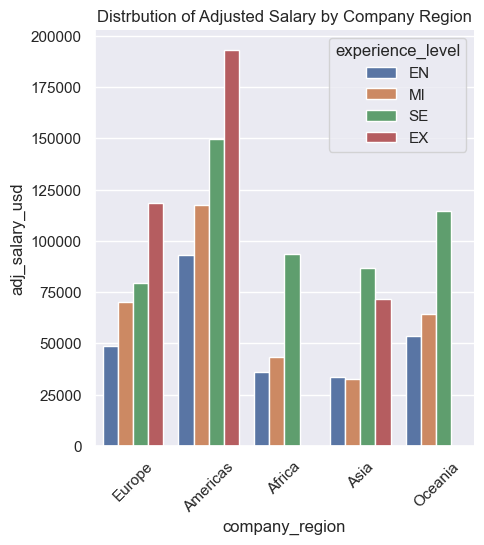

In [458]:
sns.catplot(data=salary_df,x="company_region",y="adj_salary_usd", hue="experience_level",kind='bar',hue_order=['EN','MI','SE','EX'],
               ci=None,legend_out=False)
plt.xticks(rotation=45)
plt.title('Distrbution of Adjusted Salary by Company Region')


<Axes: xlabel='company_region', ylabel='adj_salary_usd'>

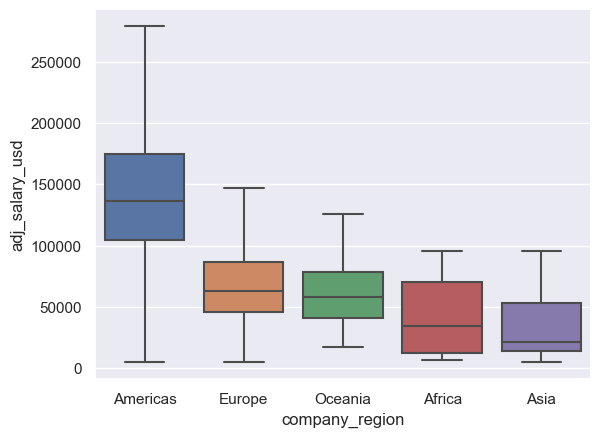

In [710]:
agg_df=salary_df.groupby('company_region')['adj_salary_usd'].agg('median').sort_values(ascending=False)
sns.boxplot(data=salary_df, y="adj_salary_usd", x="company_region",sym='',order=list(agg_df.index))

# 3. Pre-Processing

In [360]:
for feature in salary_df.columns:
    if len(salary_df[feature].value_counts())<15:
        print(salary_df[feature].value_counts())
print(salary_df.nunique())

work_year
2023    1785
2022    1664
2021     230
2020      76
Name: count, dtype: int64
experience_level
SE    2516
MI     805
EN     320
EX     114
Name: count, dtype: int64
employment_type
FT    3718
PT      17
CT      10
FL      10
Name: count, dtype: int64
job_title
Data Engineer                1040
others                        871
Data Scientist                840
Data Analyst                  612
Machine Learning Engineer     289
Analytics Engineer            103
Name: count, dtype: int64
remote_ratio
0      1923
100    1643
50      189
Name: count, dtype: int64
company_size
M    3153
L     454
S     148
Name: count, dtype: int64
employee_region
Americas    3140
Europe       464
Asia         120
Africa        17
Oceania       14
Name: count, dtype: int64
company_region
Americas    3168
Europe       458
Asia          97
Oceania       18
Africa        14
Name: count, dtype: int64
work_year              4
experience_level       4
employment_type        4
job_title              6
re

In [361]:
maplist_oe = [{'col': 'experience_level','mapping': {'EN': 0, 'MI': 1,'SE':2,'EX':3}},\
              {'col': 'company_size', 'mapping':{'S': 0, 'M': 1,'L':2}}]
enc_oe = OrdinalEncoder(mapping=maplist_oe)
salary_df=enc_oe.fit_transform(salary_df)

print(salary_df.shape)

(3755, 9)


In [362]:
columns_be=['remote_ratio','employee_region','company_region','employment_type','job_title']            
salary_df = pd.get_dummies(salary_df,columns=columns_be,drop_first=True,dtype=float)
#salary_df.head()

In [363]:
salary_df.head()

,work_year,experience_level,company_size,adj_salary_usd,remote_ratio_50,remote_ratio_100,employee_region_Americas,employee_region_Asia,employee_region_Europe,employee_region_Oceania,...,company_region_Europe,company_region_Oceania,employment_type_FL,employment_type_FT,employment_type_PT,job_title_Data Analyst,job_title_Data Engineer,job_title_Data Scientist,job_title_Machine Learning Engineer,job_title_others
0,2023,2,2,81759.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2023,1,0,28571.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2023,1,0,24286.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2023,2,1,166667.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2023,2,1,114286.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# 4. Modeling